# Playing with Google Stock Data

In this notebook we will learn about 
* Resampling
* Time-Shifts
* Rolling Windows

In [66]:
import pandas as pd

In [16]:
# Load Google Data
goog = pd.read_csv('GOOG.csv', index_col='Date', parse_dates=True)
goog.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-08-19,49.676899,51.693783,47.669952,49.845802,49.845802,44994500
2004-08-20,50.178635,54.187561,49.925285,53.805050,53.805050,23005800
2004-08-23,55.017166,56.373344,54.172661,54.346527,54.346527,18393200
2004-08-24,55.260582,55.439419,51.450363,52.096165,52.096165,15361800
2004-08-25,52.140873,53.651051,51.604362,52.657513,52.657513,9257400


In [17]:
# For simplicity, we'll use closing price
goog = goog['Close']

In [18]:
# Viz the data
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn; seaborn.set()

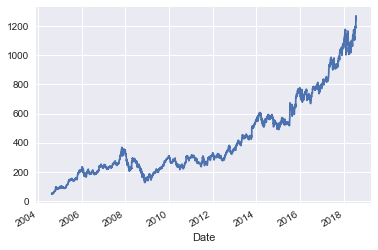

In [19]:
goog.plot()

### Resampling and converting frequencies

Resampling involves changing the frequency of our time series observations.

Two types of resampling are:

1. **Upsampling**: Increase the frequency of the samples, such as from minutes to seconds.
2. **Downsampling**: Decrease the frequency of the samples, such as from days to months.

Reasons to use Resampling:

1. **Problem Framing**: Resampling may be required if our data is available at the same frequency that you want to make predictions.
2. **Feature Engineering**: Resampling can also be used to provide additional structure or insight into the learning problem for supervised learning models.

This can be done using the `resample()` method, or the much simpler `asfreq()` method. The primary difference between the two is that `resample()` is fundamentally a _data aggregation_, while `asfreq()` is fundamentally a _data selection_.


Taking a look at the GOOG closing price, let's compare what the two return when we down-sample the data. Here we will resample the data at the end of business year (BA):

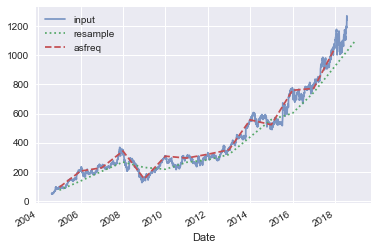

In [28]:
goog.plot(alpha=0.7, style='-')
goog.resample('BA').mean().plot(style=':')
goog.asfreq('BA').plot(style='--')
plt.legend(['input', 'resample', 'asfreq'],
           loc='upper left');

Looking at plot we can see that:<br>
`resample` reports the average of the previous year.<br>
`asfreq` reports the value at end of the year.

For up-scaling, both are lagerly equivalent, though resample has many more options available.Here, we will resample the business day data at a daily frequency (i.e., including weekends):

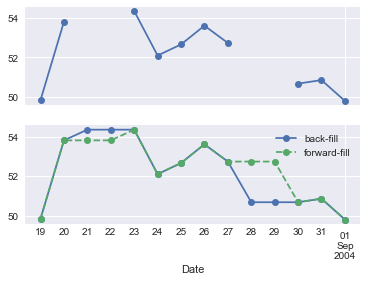

In [42]:
fig, ax = plt.subplots(2, sharex=True)
data = goog.iloc[:10]
data.asfreq('D').plot(ax=ax[0], marker='o')

data.asfreq('D', method='bfill').plot(ax=ax[1], style='-o')
data.asfreq('D', method='ffill').plot(ax=ax[1], style='--o')
ax[1].legend(["back-fill", "forward-fill"]);

The top panel is the default: non-business days are left as NA values and do not appear on the plot. The bottom pamel shows the differences between two strategies for filling the gaps: forward-filling and backward-filling.

## Time-Shifts

Another common time series-specific operation is shifting of data in time. Pandas has two closely realted methods for computing this: `shift()` and `tshift()` In short, the difference between them is that `shift()` _shifts the data_, while `tshifts the index_`. In both cases, the shift is specified in multiples of the frequency.

Here we will both `shift()` and `tshift()` by 900 days;

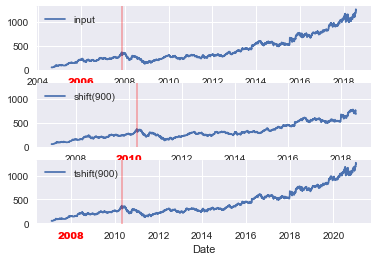

In [55]:
fig, ax = plt.subplots(3, sharey=True)

# apply a frequency to the data
goog = goog.asfreq('D', method='pad')

goog.plot(ax=ax[0])
goog.shift(900).plot(ax=ax[1])
goog.tshift(900).plot(ax=ax[2])

# legends and annotations
local_max = pd.to_datetime('2007-11-05')
offset = pd.Timedelta(900, 'D')

ax[0].legend(['input'], loc=2)
ax[0].get_xticklabels()[2].set(weight='heavy', color='red')
ax[0].axvline(local_max, alpha=0.3, color='red')

ax[1].legend(['shift(900)'], loc=2)
ax[1].get_xticklabels()[2].set(weight='heavy', color='red')
ax[1].axvline(local_max + offset, alpha=0.3, color='red')

ax[2].legend(['tshift(900)'], loc=2)
ax[2].get_xticklabels()[1].set(weight='heavy', color='red')
ax[2].axvline(local_max + offset, alpha=0.3, color='red');

We see here that `shift(900)` shifts the _data_ by 900 days, pushing some of it off the end of the graph (and leaving NA values at the other end), while `tshift(900)` shifts the _index values_ by 900 days.

A common context for this type of shift is in computing difference over time. For example, we use shifted values to compute the **one-year return on investment** for Google stock over the course of the dataset:

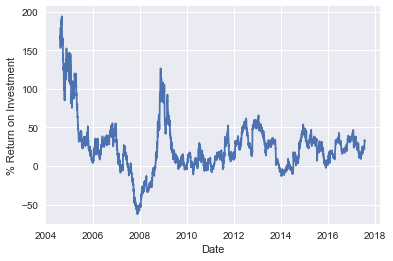

In [56]:
ROI = 100 * (goog.tshift(-365) / goog - 1)
ROI.plot()
plt.ylabel('% Return on Investment');

This helps us to see the overall trend in Google stock: thus far, the most profitable times to invest in Google have been (unsurprisingly, in retrospect) shortly after its IPO, and in the middle of the 2009 recession.

## Rolling windows

Rolling statistics are a third type of time series-specific operation implemented by Pandas. These can be accomplished via the `rolling()` attribute of `Series` and `DataFrame` objects.

For example, here is the one-year centered rolling mean and standard deviation of the Google stock prices: 

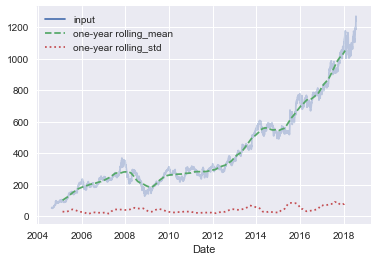

In [65]:
rolling = goog.rolling(365, center=True)


data = pd.DataFrame({'input': goog,
                     'one-year rolling_mean': rolling.mean(),
                     'one-year rolling_std': rolling.std()})
ax = data.plot(style=['-', '--', ':'])
ax.lines[0].set_alpha(0.3)